In [1]:
import numpy as np
import os
import subprocess
#import theano
import gzip

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import regularizers

import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Conv1D, BatchNormalization, Flatten
from keras.optimizers import Adagrad, Adam
from keras.utils import plot_model
from keras import regularizers

from keras.utils import plot_model
import matplotlib.pyplot as plt
import pickle
#from keras.models import load_model


Using TensorFlow backend.


In [ ]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [2]:
def get_split(X_train, X_valid, classSize, pssm = False):

    if not pssm:
        return (X_train[:,:,0:21], X_train[:,:,21 : (21+classSize)], 
                X_valid[:,:,0:21], X_valid[:,:,21 : (21+classSize)])
    else:
        return (X_train[:,:,21+classSize:], X_train[:,:,21 : (21+classSize)],
                X_valid[:,:,21+classSize:], X_valid[:,:,21 : (21+classSize)])

In [3]:
windowSize = 19 #19
predictionIndex = 9
classSize = 8  # 2 or 3 
numberOfFeatures = 50 #50 #44 #45


In [ ]:
X_train_window = np.load('X_train_window19Middle.npy') # load
X_valid_window = np.load('X_valid_window19Middle.npy') # load

In [4]:
f = gzip.GzipFile('X_train_window19Middle.npy.gz', "r")
X_train_window = np.load(f)

In [5]:
f = gzip.GzipFile('X_valid_window19Middle.npy.gz', "r")
X_valid_window = np.load(f)

In [6]:
#a = get_tapped_one_dataset(X_train_window, windowSize, classSize)
#b = get_tapped_one_dataset(X_valid_window, windowSize, classSize)

x_train_final, y_train_final, x_valid_final, y_valid_final = get_split(X_train_window, X_valid_window, classSize, pssm = True)
print(x_train_final.shape, "training data")
print(y_train_final.shape, "labels for training data")
print(x_valid_final.shape, "validation data")
print(y_valid_final.shape, "labels for training validation")

y_train_final = y_train_final[:,0,:]
print(y_train_final.shape)

y_valid_final = y_valid_final[:,0,:]
print(y_valid_final.shape)

(1082350, 19, 21) training data
(1082350, 19, 8) labels for training data
(51152, 19, 21) validation data
(51152, 19, 8) labels for training validation
(1082350, 8)
(51152, 8)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf


nn_epochs = 15

   
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.1
batch_dim = 64

loss = 'categorical_crossentropy'

input_shape = (windowSize, 21)

conv1_input = Input(shape=(windowSize, 21), name='InputWindow')
conv_1 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv1_input)
conv_1 = BatchNormalization(name='BN1')(conv_1)
conv_1 = Dropout(drop_out)(conv_1)
conv_2 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_1)
conv_2 = BatchNormalization(name='BN2')(conv_2)
conv_2 = Dropout(drop_out)(conv_2)
conv_3 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_2)
conv_3 = BatchNormalization(name='BN3')(conv_3)
conv_3 = Dropout(drop_out)(conv_3)



conv_4 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_3)
conv_4 = BatchNormalization(name='BN4')(conv_4)
conv_4 = Dropout(drop_out)(conv_4)
conv_5 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_4)
conv_5 = BatchNormalization(name='BN5')(conv_5)
conv_5 = Dropout(drop_out)(conv_5)
    #conv_6 = Conv1D( 73, 3, strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_5)
    #conv_6 = BatchNormalization(name='BN6')(conv_6)


    #conv_7 = Conv1D( 73, 3,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg)(conv_6)
    #conv_7 = BatchNormalization(name='BN7')(conv_7)
    #conv_8 = Conv1D( 4, 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_7)
    #conv_8 = BatchNormalization(name='BN8')(conv_8)
    #conv_9 = Conv1D( 4, 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_8)
    #conv_9 = BatchNormalization(name='BN9')(conv_9)


flatten  = Flatten()(conv_5)
first_dense = Dense(256, activation='relu', use_bias=True)(flatten)
second_dense = Dense(64, activation='relu', use_bias=True)(first_dense)

final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(second_dense)

m = Model(inputs=conv1_input, outputs=final_model_output)

opt = Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
#print("Regularizers: " + str(w_reg.l2))
print("\nLoss: " + loss + "\n")
m.summary()

#import os
 #os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

 #plot_model(m)#, to_file='model.png')

    

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf



nn_epochs = 35
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.3
batch_dim = 64

loss = 'categorical_crossentropy'

conv1_input = Input(shape=(windowSize, 21), name='InputWindow')
conv_1 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv1_input)
conv_1 = BatchNormalization(name='BN1')(conv_1)
conv_1 = Dropout(drop_out)(conv_1)

conv_2 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_1)
conv_2 = BatchNormalization(name='BN2')(conv_2)
conv_2 = Dropout(drop_out)(conv_2)

conv_3 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(concatenate([conv1_input, conv_2]))
conv_3 = BatchNormalization(name='BN3')(conv_3)
conv_3 = Dropout(drop_out)(conv_3)

conv_4 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_3)
conv_4 = BatchNormalization(name='BN4')(conv_4)
conv_4 = Dropout(drop_out)(conv_4)

conv_5 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(concatenate([conv1_input, conv_4]))
conv_5 = BatchNormalization(name='BN5')(conv_5)
conv_5 = Dropout(drop_out)(conv_5)




merge_final = concatenate([conv_1, conv_3, conv_5], name='Final')


flatten  = Flatten()(merge_final)
first_dense = Dense(128, activation='relu', use_bias=True)(flatten)
second_dense = Dense(32, activation='relu', use_bias=True)(first_dense)

final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(second_dense)

m = Model(inputs=conv1_input, outputs=final_model_output)

opt = Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
#print("Regularizers: " + str(w_reg.l2))
print("\nLoss: " + loss + "\n")
m.summary()

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

#plot_model(m)#, to_file='model.png')

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf



nn_epochs = 25
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.22
batch_dim = 64

loss = 'categorical_crossentropy'

conv1_input = Input(shape=(windowSize, 21), name='InputWindow')
conv_1 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv1_input)
conv_1 = BatchNormalization(name='BN1')(conv_1)
conv_1 = Dropout(drop_out)(conv_1)

conv_2 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_1)
conv_2 = BatchNormalization(name='BN2')(conv_2)
conv_2 = Dropout(drop_out)(conv_2)

conv_3 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_2)
conv_3 = BatchNormalization(name='BN3')(conv_3)
conv_3 = Dropout(drop_out)(conv_3)

conv_4 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_3)
conv_4 = BatchNormalization(name='BN4')(conv_4)
conv_4 = Dropout(drop_out)(conv_4)

conv_5 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_4)
conv_5 = BatchNormalization(name='BN5')(conv_5)
conv_5 = Dropout(drop_out)(conv_5)


input_for_second = concatenate([conv1_input, conv_5], name='Network1-and-input')



conv_6 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(input_for_second)
conv_6 = BatchNormalization(name='BN6')(conv_6)
conv_6 = Dropout(drop_out)(conv_6)

conv_7 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_6)
conv_7 = BatchNormalization(name='BN7')(conv_7)
conv_7 = Dropout(drop_out)(conv_7)

conv_8 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_7)
conv_8 = BatchNormalization(name='BN8')(conv_8)
conv_8 = Dropout(drop_out)(conv_8)

conv_9 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_8)
conv_9 = BatchNormalization(name='BN9')(conv_9)
conv_9 = Dropout(drop_out)(conv_9)

conv_10 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_9)
conv_10 = BatchNormalization(name='BN10')(conv_10)
conv_10 = Dropout(drop_out)(conv_10)


input_for_third = concatenate([conv1_input, conv_5, conv_10],name='Network1-Network2-and-input')



conv_11 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(input_for_third)
conv_11 = BatchNormalization(name='BN11')(conv_11)
conv_11 = Dropout(drop_out)(conv_11)

conv_12 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_11)
conv_12 = BatchNormalization(name='BN12')(conv_12)
conv_12 = Dropout(drop_out)(conv_12)

conv_13 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_12)
conv_13 = BatchNormalization(name='BN13')(conv_13)
conv_14 = Dropout(drop_out)(conv_13)

conv_14 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_13)
conv_14 = BatchNormalization(name='BN14')(conv_14)
conv_14 = Dropout(drop_out)(conv_14)

conv_15 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_14)
conv_15 = BatchNormalization(name='BN15')(conv_15)
conv_15 = Dropout(drop_out)(conv_15)



merge_final = concatenate([conv_5, conv_10, conv_15], name='Final')


flatten  = Flatten()(merge_final)
first_dense = Dense(256, activation='relu', use_bias=True)(flatten)
second_dense = Dense(64, activation='relu', use_bias=True)(first_dense)

final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(second_dense)

m = Model(inputs=conv1_input, outputs=final_model_output)

opt = Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
#print("Regularizers: " + str(w_reg.l2))
print("\nLoss: " + loss + "\n")
m.summary()

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

#plot_model(m)#, to_file='model.png')


Hyper Parameters

Learning Rate: 0.0009
Drop out: 0.22
Batch dim: 64
Number of epochs: 25

Loss: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputWindow (InputLayer)        (None, 19, 21)       0                                            
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 19, 64)       4096        InputWindow[0][0]                
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 19, 64)       256         conv1d_46[0][0]                  
__________________________________________________________________________________________________
dropout_46 (Dropout)            (None, 19, 64)       0           BN1[0][0]          

In [9]:
from keras.callbacks import ModelCheckpoint

filepath="best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)
callbacks_list = [checkpoint]

In [21]:
from time import time
from timeit import default_timer as timer

start_time = timer()
history = m.fit(x_train_final, y_train_final, epochs=nn_epochs, batch_size=batch_dim,
                validation_data=(x_valid_final, y_valid_final) ,shuffle=True,  callbacks=callbacks_list)

end_time = timer()
print("\n\nTime elapsed: " + "{0:.2f}".format((end_time - start_time)) + " s")

Train on 1082350 samples, validate on 51152 samples
Epoch 1/25
1082350/1082350 [==============================] - 420s 388us/step - loss: 0.9475 - acc: 0.6577 - mean_absolute_error: 0.1118 - val_loss: 0.8408 - val_acc: 0.6968 - val_mean_absolute_error: 0.1009

Epoch 00001: val_acc did not improve from 0.73072
Epoch 2/25
1082350/1082350 [==============================] - 423s 391us/step - loss: 0.8566 - acc: 0.6902 - mean_absolute_error: 0.1023 - val_loss: 0.8041 - val_acc: 0.7063 - val_mean_absolute_error: 0.0981

Epoch 00002: val_acc did not improve from 0.73072
Epoch 3/25
1082350/1082350 [==============================] - 423s 391us/step - loss: 0.8260 - acc: 0.7002 - mean_absolute_error: 0.0992 - val_loss: 0.7938 - val_acc: 0.7127 - val_mean_absolute_error: 0.0940

Epoch 00003: val_acc did not improve from 0.73072
Epoch 4/25
1082350/1082350 [==============================] - 423s 391us/step - loss: 0.8084 - acc: 0.7069 - mean_absolute_error: 0.0973 - val_loss: 0.7829 - val_acc: 0.71

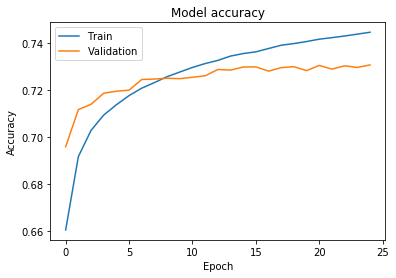

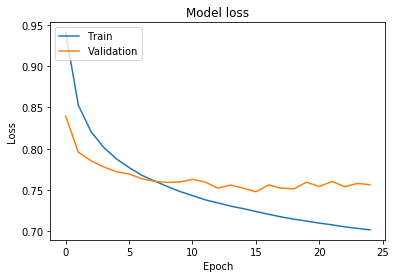

In [13]:


accuracyName = 'accuracyMiddlewindowQ2W19Model2.png'
lossName = 'lossMiddlewindowQ2W19Model2.png'

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig(accuracyName)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig(lossName)
plt.show()




In [14]:
f = gzip.GzipFile('cb513_window19Q8.npy.gz', "r")
X_test_window = np.load(f)

In [ ]:
c = get_tapped_one_dataset(X_test_window, windowSize, classSize)
print(c.shape)

In [15]:
x_test_final = X_test_window[:,:,(21+classSize):]
#x_test_final = X_test_window[:,:,0:21]
y_test_final = X_test_window[:,:,21: (21+classSize)]
print(x_test_final.shape)
print(y_test_final.shape)

(80119, 19, 21)
(80119, 19, 8)


In [16]:
y_test_final = np.reshape(y_test_final, (80119,19*8))
print(y_test_final.shape)
y_test_final = y_test_final[:,0:8]
print(y_test_final.shape)

(80119, 152)
(80119, 8)


In [18]:
from keras.models import load_model

model = load_model('best.hdf5')

In [ ]:
scores = m.evaluate(x_test_final, y_test_final)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))
print("yes boi")

 4000/80119 [>.............................] - ETA: 13s

In [ ]:
fold = 3
m.save('model_' + str(fold) + '.h5')  # creates a HDF5 file 
with open('model_scores_' + str(fold), 'wb') as file_pi:
    pickle.dump(scores, file_pi)
with open('model_history_' + str(fold), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)